**Your tasks this week:**
1. Write a function to display stock market financial data using candlestick chart. You can use
the following tutorial: https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-
python-mplfinance-plotly-bokeh but, again, you will need to explain in details all the code in
your program (including the meanings of the arguments in a function call). Furthermore, you
need to include an option in your function to allow each candle stick to express the data of n
trading days (n ≥ 1).
2. Write a function to display stock market financial data using boxplot chart. This is
particularly useful when you are trying to display your data for a moving window of n
consecutive trading days. Again, feel free to use online resources that teach you how to do
this but you need to add comments to explain your codes and the parameters you use.
3. Upload your Task 3 Report (as a PDF file) to the project Wiki before the deadline and email
your project leader to notify that it is ready for viewing and feedback.

In [1]:
!nvidia-smi

Thu Aug 31 03:35:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install --upgrade mplfinance

# Code Source Note: https://github.com/twopirllc/pandas-ta
!pip install -q pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/DataProcessing2'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer, Input, Activation
from tensorflow.keras.utils import plot_model

import joblib

In [5]:
start='2015-01-01'
end='2023-08-25'
ticker='TSLA'

# Price Value
price_value = 'Close' # This can be change to 'Open', 'Close', 'Adj Close , 'High', 'Low'

# Split Dataset for Training/Testing
split_ratio=0.8

# Number of look back days to base the prediction
step_size = 30 # Can be changed

# Directory
DATA_DIR = os.path.join(SKELETON_DIR, "data")
PREPARED_DATA_DIR = os.path.join(SKELETON_DIR, "prepared-data")

# File Path
CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_TRAIN = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}-{ticker}_prepared_data.npz")
TRAIN_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TrainData-from-{start}to-{end}-{ticker}_stock_data.csv")
TEST_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TestData-from-{start}to-{end}-{ticker}_stock_data.csv")
SCALER_FEATURE_FILE = os.path.join(PREPARED_DATA_DIR, f"FeatureScaler-from-{start}to-{end}-{ticker}.pkl")
SCALER_TARGET_FILE = os.path.join(PREPARED_DATA_DIR, f"TargetScaler-from-{start}to-{end}-{ticker}.pkl")
TRAIN_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_train_arrays.npz")
TEST_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_test_arrays.npz")

In [6]:
# Double check directory
def ensure_directory_exists(dir_path):
  # If directory not exist => create
  if not os.path.isdir(dir_path):
      os.mkdir(dir_path)

In [7]:
# Save and Load utility functions
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        joblib.dump(obj, f)

def load_object(filename):
    with open(filename, 'rb') as f:
        return joblib.load(f)

In [8]:
# Load Raw Data
def load_data(start, end, ticker, source='yahoo'):
  ensure_directory_exists(DATA_DIR)

  # Check if CSV file exists
  # If exist => load
  # If not exist => download
  if os.path.exists(CSV_FILE):
      print('Loading Existing Data')
      data = pd.read_csv(CSV_FILE)
  else:
      print('Downloading Data')
      data = yf.download(ticker, start, end, progress=False)
      data.to_csv(CSV_FILE)

  return data

In [9]:
# Data Validation
def data_validation(start, end, ticker):
  ensure_directory_exists(PREPARED_DATA_DIR)


  if os.path.exists(PREPARED_DATA_FILE):
      print('Loading Prepared Data')
      df = pd.read_csv(PREPARED_DATA_FILE)
  else:
      print('Processing Raw Data')

      # Read Raw Data File
      df = pd.read_csv(CSV_FILE)

      df['Date'] = pd.to_datetime(df['Date'])

      df.set_index('Date', inplace=True)

      # Adding indicators
      df['RSI']=ta.rsi(df.Close, length=15)
      df['EMAF']=ta.ema(df.Close, length=20)
      df['EMAM']=ta.ema(df.Close, length=100)
      df['EMAS']=ta.ema(df.Close, length=150)

      df['Target'] = df['Adj Close']-df.Open
      df['Target'] = df['Target'].shift(-1)

      df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]

      df['TargetNextClose'] = df['Adj Close'].shift(-1)

      # Drop NaN issue in data
      df.dropna(inplace=True)

      # Drop Columns
      # df.drop(['Volume','Close', 'Date'], axis=1, inplace=True)

      # Export Prepared Data
      df.to_csv(PREPARED_DATA_FILE)

  return df

In [10]:
# Split Data by Date or Randomly
def split_data(df, split_ratio, split_by_date=True):
    if split_by_date:
        # Split by date
        train_size = int(len(df) * split_ratio)
        train_data = df.iloc[:train_size]
        test_data = df.iloc[train_size:]
    else:
        # Split Randomly
        train_data, test_data = train_test_split(df, test_size=1-split_ratio, random_state=42)

    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data


In [11]:
# Scaler
def scaler_features(input_data, scale=True):
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Reshaping if input_data is a Series or 1D numpy array
        if len(input_data.shape) == 1:
            input_data = input_data.values.reshape(-1, 1)

        scaled_data = scaler.fit_transform(input_data)
        return scaled_data, scaler
    else:
        return input_data, None


In [12]:
def create_datasets(start, end, ticker):

    # Download or Load Raw Data
    data = load_data(start, end, ticker)

    # Data Validation
    df = data_validation(start, end, ticker)

    if os.path.exists(TRAIN_DATA_FILE) and os.path.exists(TEST_DATA_FILE):
        print('Loading Existing Train and Test Data')
        train_data = pd.read_csv(TRAIN_DATA_FILE)
        test_data = pd.read_csv(TEST_DATA_FILE)

        print(f"Train Data Shape: {train_data.shape}")
        print(f"Test Data Shape: {test_data.shape}")

        # Load feature and target scalers
        train_feature_scaler = load_object(SCALER_FEATURE_FILE)
        train_target_scaler = load_object(SCALER_TARGET_FILE)

        # Load x_train, y_train, x_test, y_test
        train_arrays = np.load(TRAIN_ARRAY_FILE)
        x_train = train_arrays['x_train']
        y_train = train_arrays['y_train']

        test_arrays = np.load(TEST_ARRAY_FILE)
        x_test = test_arrays['x_test']
        y_test = test_arrays['y_test']

    else:
        print('Processing Train and Test Data')
        # Split Data
        train_data, test_data = split_data(df, split_ratio)

        # Define features and target
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
        target_column = 'TargetNextClose'

        # Preparing Train Datasets
        # Scaler for features
        scaled_data_train, train_feature_scaler = scaler_features(train_data[feature_columns])
        # Scaler for target
        scaled_target_train, train_target_scaler = scaler_features(train_data[target_column].values.reshape(-1, 1))

        x_train, y_train = [], []
        for i in range(step_size, len(scaled_data_train)):
            x_train.append(scaled_data_train[i-step_size:i])
            y_train.append(scaled_target_train[i])

        x_train, y_train = np.array(x_train), np.array(y_train)

        # Preparing Test Datasets
        # Use the feature scaler to scale the test data
        scaled_data_test = train_feature_scaler.transform(test_data[feature_columns])
        # Use the target scaler to scale the test target
        scaled_target_test = train_target_scaler.transform(test_data[target_column].values.reshape(-1, 1))

        x_test, y_test = [], []
        for i in range(step_size, len(scaled_data_test)):
            x_test.append(scaled_data_test[i-step_size:i])
            y_test.append(scaled_target_test[i])

        x_test, y_test = np.array(x_test), np.array(y_test)

        # Save train_data and test_data
        train_data.to_csv(TRAIN_DATA_FILE)
        test_data.to_csv(TEST_DATA_FILE)

        # Save feature and target scalers
        save_object(train_feature_scaler, SCALER_FEATURE_FILE)
        save_object(train_target_scaler, SCALER_TARGET_FILE)

        # Save x_train, y_train, x_test, y_test
        np.savez(TRAIN_ARRAY_FILE, x_train=x_train, y_train=y_train)

        np.savez(TEST_ARRAY_FILE, x_test=x_test, y_test=y_test)

    # For data
    if not isinstance(data.index, pd.DatetimeIndex):
        if "Date" in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

    # For df
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)

    # For train_data
    if not isinstance(train_data.index, pd.DatetimeIndex):
        if "Date" in train_data.columns:
            train_data['Date'] = pd.to_datetime(train_data['Date'])
            train_data.set_index('Date', inplace=True)

    # For test_data
    if not isinstance(test_data.index, pd.DatetimeIndex):
        if "Date" in test_data.columns:
            test_data['Date'] = pd.to_datetime(test_data['Date'])
            test_data.set_index('Date', inplace=True)


    return data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test


In [13]:
data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test = create_datasets(start, end, ticker)

Processing Raw Data
Processing Train and Test Data
Train Data Shape: (1620, 13)
Test Data Shape: (406, 13)


In [14]:
print("Data shapes/types:")
print("data:", type(data))
print("df:", type(df))
print("train_data:", train_data.shape)
print("test_data:", test_data.shape)
print("train_feature_scaler:", type(train_feature_scaler))
print("train_target_scaler:", type(train_target_scaler))
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data shapes/types:
data: <class 'pandas.core.frame.DataFrame'>
df: <class 'pandas.core.frame.DataFrame'>
train_data: (1620, 13)
test_data: (406, 13)
train_feature_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
train_target_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train: (1590, 30, 10)
x_test: (376, 30, 10)
y_train: (1590, 1)
y_test: (376, 1)


In [15]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500


In [16]:
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600
2023-08-24,238.660004,238.919998,228.179993,230.039993,230.039993,99777400


In [17]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [18]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,41.132038,243.068776,230.590960,223.752151,-7.059998,0,233.190002
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900,42.417038,242.127941,230.642426,223.877156,7.520004,1,236.860001
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600,44.893445,241.626232,230.765546,224.049114,-8.620010,0,230.039993


In [19]:
train_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [20]:
train_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600,51.079304,354.262754,316.084408,295.390988,-17.803314,0,342.320007
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700,47.672453,353.125350,316.603925,296.012565,19.373322,1,352.706665
2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000,50.587870,353.085475,317.318831,296.763480,3.576660,1,354.799988


In [21]:
test_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-11,351.223328,358.616669,346.273346,354.799988,354.799988,66063300,51.175269,353.248762,318.061032,297.532176,9.123322,1,368.739990
2022-01-12,359.616669,371.613342,357.529999,368.739990,368.739990,83739000,54.992715,354.724117,319.064576,298.475325,-25.836670,0,343.853333
2022-01-13,369.690002,371.866669,342.179993,343.853333,343.853333,97209900,47.838278,353.688804,319.555442,299.076359,9.910004,1,349.869995


In [22]:
test_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,41.132038,243.068776,230.590960,223.752151,-7.059998,0,233.190002
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900,42.417038,242.127941,230.642426,223.877156,7.520004,1,236.860001
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600,44.893445,241.626232,230.765546,224.049114,-8.620010,0,230.039993


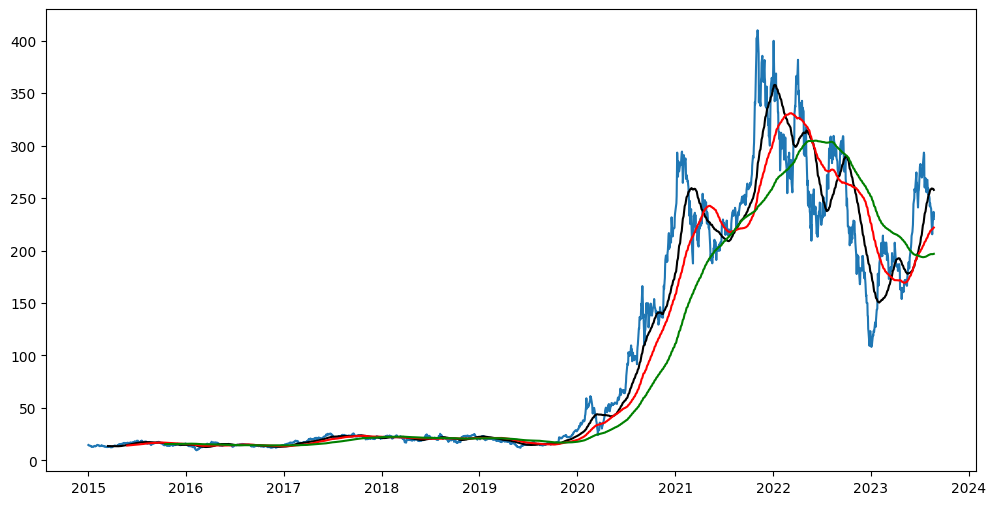

In [23]:
# Moving Avg
ma50 = data[price_value].rolling(50).mean()
ma100 = data[price_value].rolling(100).mean()
ma200 = data[price_value].rolling(200).mean()

# Plot Chart with MA
plt.figure(figsize=(12,6))
plt.plot(data.Close)
plt.plot(ma50, 'k')
plt.plot(ma100,'r')
plt.plot(ma200,'g')

# plot_candlestick

**The function `plot_candlestick` takes the following parameters:**

1. `input_df`: This parameter represents the input DataFrame containing financial data that you want to plot as a candlestick chart.

2. `n`: This is an optional parameter (defaulting to 1) that indicates the resampling period in trading days for aggregating the data.

**This function has the following features:**

1. **Copying the DataFrame:** The input DataFrame is copied to avoid modifying the original data. The purpose of copying is to prevent any unintended modifications and warnings.

2. **Resampling Data:** If `n` is greater than 1, the function resamples the data based on the specified trading days (`n`). It aggregates the data to find the first open, maximum high, minimum low, last close, and sum of volumes within each resampling period.

3. **Adding Moving Averages:** The function calculates three moving averages (MA) for the 'Close' price: a 50-day moving average (`MA50`), a 100-day moving average (`MA100`), and a 200-day moving average (`MA200`). These moving averages are added as columns to the DataFrame.

4. **Creating Additional Plot Elements:** The function creates a list of addplot objects using the moving averages (`MA50`, `MA100`, `MA200`) as additional plot elements. These will be displayed alongside the main candlestick chart.

5. **Plotting the Chart:** The function uses the `mpf.plot` function from the mplfinance library to plot the candlestick chart. Various parameters are specified for chart appearance, including chart type, title, labels, volume bars, and the additional plot elements created earlier.

In [35]:
def plot_candlestick(input_df, n=1):

    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df['Close'].rolling(window=50).mean()
    input_df['MA100'] = input_df['Close'].rolling(window=100).mean()
    input_df['MA200'] = input_df['Close'].rolling(window=200).mean()

    # Create a custom plot for the moving averages
    ap = []
    if input_df['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = input_df['MA50'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))
    if input_df['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = input_df['MA100'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))
    if input_df['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = input_df['MA200'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    # Plot the candlestick chart
    mpf.plot(input_df, type='candle', style='charles',
             title=f"{ticker} Candlestick Chart",
             ylabel='Price',
             volume=True,
             ylabel_lower='Volume',
             addplot=ap,
             show_nontrading=True)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


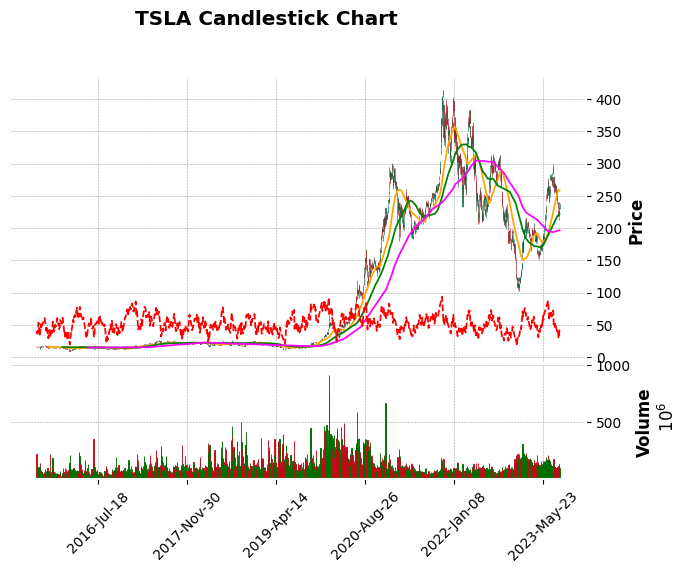

In [36]:
# Plot Raw Data
plot_candlestick(df,n=1)

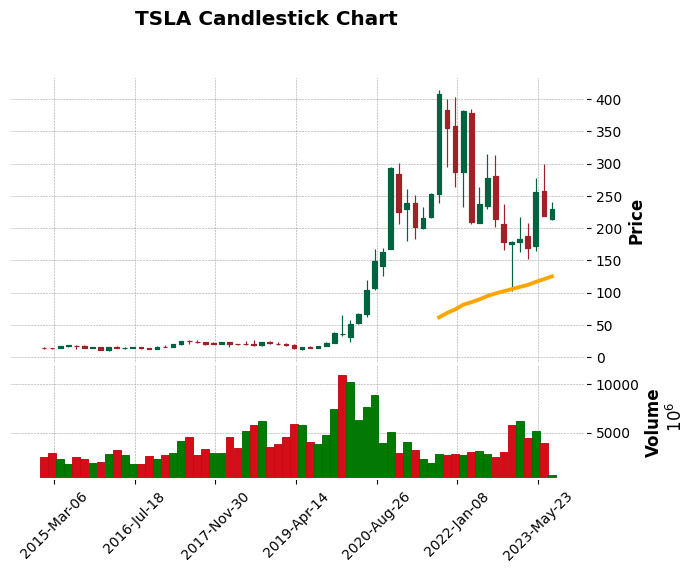

In [26]:
# Plot Raw Data
plot_candlestick(data,n=50)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


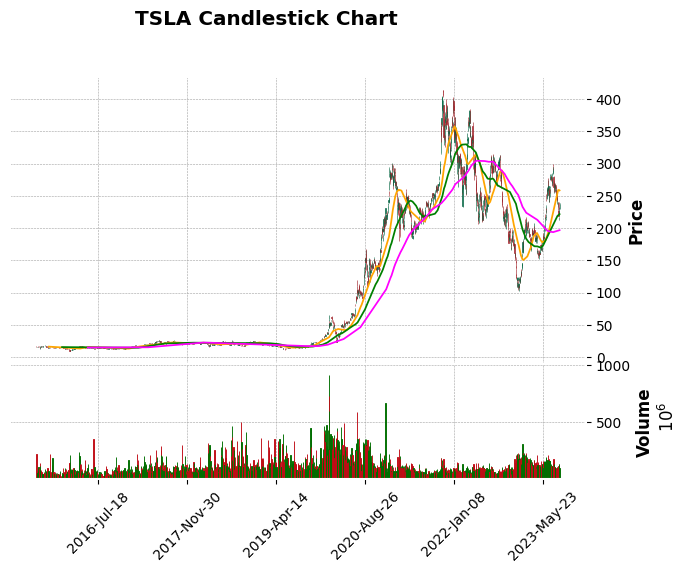

In [27]:
# Plot Validated Data
plot_candlestick(df)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


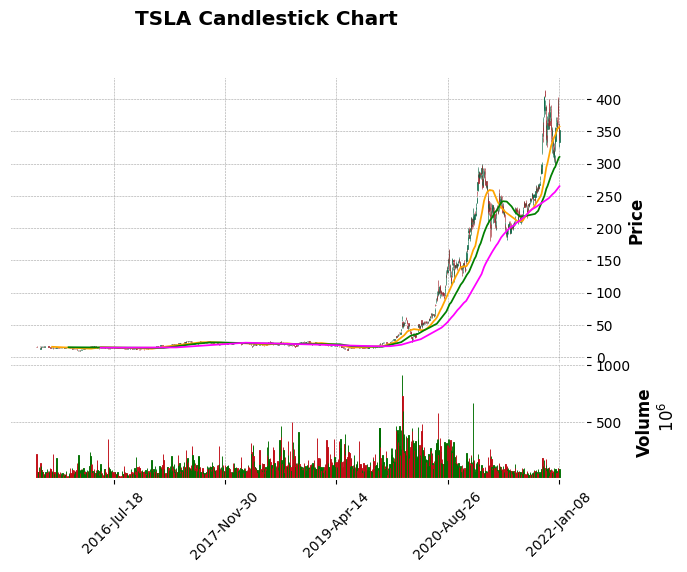

In [28]:
plot_candlestick(train_data)

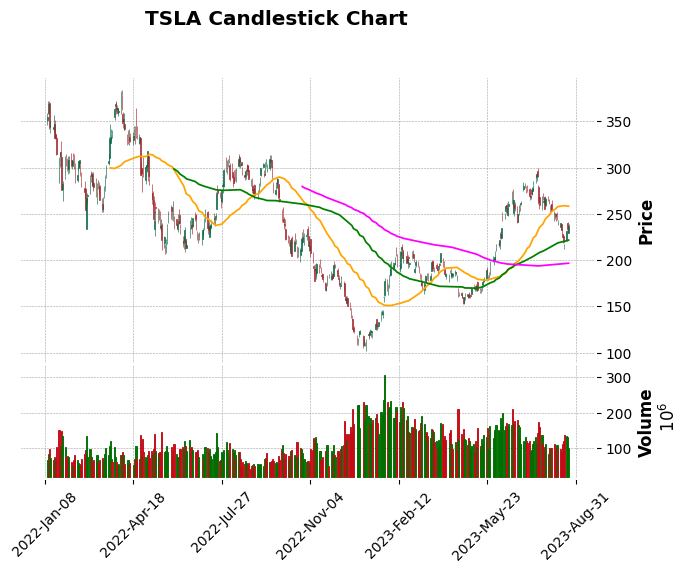

In [29]:
plot_candlestick(test_data)

# plot_boxplot

**The function `plot_boxplot` takes the following parameters:**

1. `input_df`: This parameter represents the input DataFrame that contains the financial data you want to visualize as a boxplot chart.
  
2. `n`: This is an optional parameter, defaulting to 1, that specifies the resampling period in trading days for aggregating the data.

3. `k`: This is an optional parameter, defaulting to 10, that specifies the interval for displaying x-axis labels to avoid clutter.

**This function has the following features:**

1. **Copying the DataFrame**: The input DataFrame is copied to avoid any unintended modification of the original data and to prevent warnings.

2. **Resampling Data**: If `n` is greater than 1, the function resamples the data to aggregate `n` trading days into one box. It finds the first open, maximum high, minimum low, last close, and sum of volumes for each resampling period.

3. **Preparing Data for Boxplot**: A list `box_data` is prepared, which contains lists of the ['Low', 'Open', 'Close', 'High'] prices for each period (resampled if `n > 1`). Additionally, a list `labels` contains the corresponding dates.

4. **Plotting the Chart**: The function uses matplotlib's `boxplot` function to plot the boxplot chart. Various parameters like orientation (`vert=True`) and patch artist (`patch_artist=True`) are set to control the appearance of the boxplot.

5. **Setting X-axis Labels**: To avoid clutter, x-axis labels are displayed at intervals specified by the parameter `k`. The labels are also rotated for better visibility.

6. **Setting Titles and Labels**: The title of the plot, as well as the x-axis and y-axis labels, are set for better understanding of the visualized data.

In [56]:
def plot_boxplot(input_df, n=1, k=10):
    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Prepare data for boxplot
    box_data = []
    labels = []
    for idx, row in input_df.iterrows():
        box_data.append([row['Low'], row['Open'], row['Close'], row['High']])
        labels.append(idx.strftime('%Y-%m-%d'))

    # Plotting
    fig, ax = plt.subplots()
    ax.boxplot(box_data, vert=True, patch_artist=True)
    ax.set_title(f'{ticker} Boxplot Chart')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Set x-axis labels and ticks
    ax.set_xticks(range(1, len(labels) + 1, k))
    ax.set_xticklabels(labels[::k], rotation=90)

    plt.show()

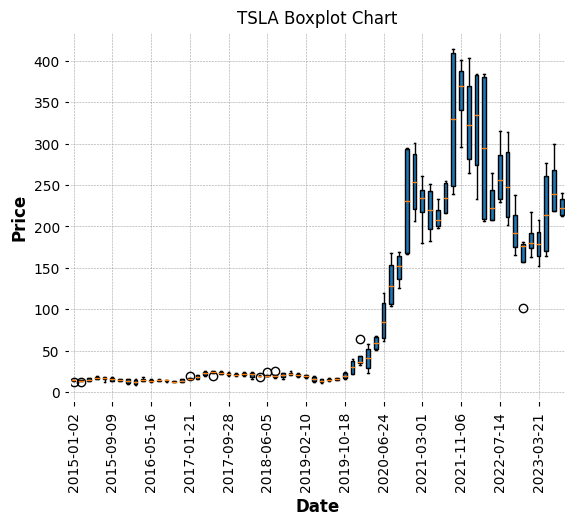

In [51]:
plot_boxplot(data, n=50, k=5)

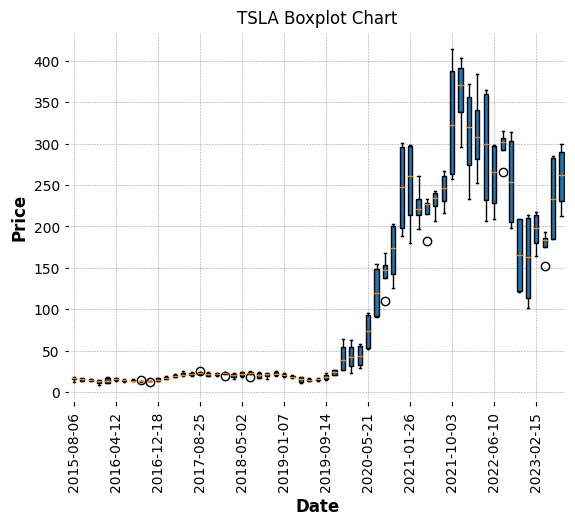

In [52]:
plot_boxplot(df, n=50, k=5)

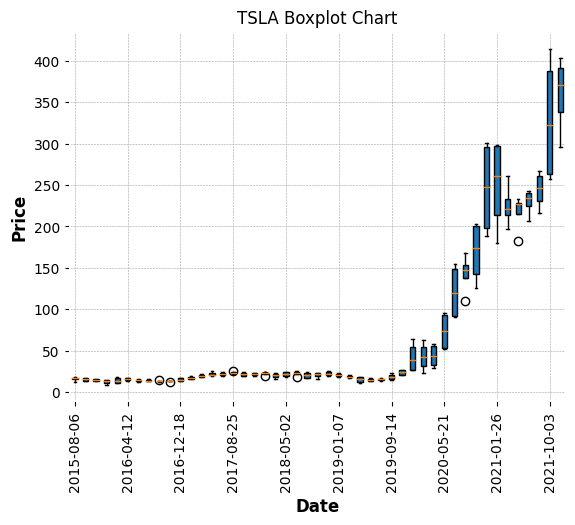

In [53]:
plot_boxplot(train_data, n=50, k=5)

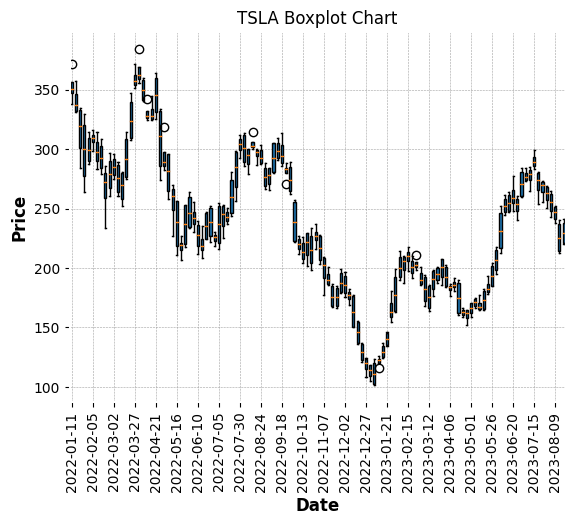

In [55]:
plot_boxplot(test_data, n=5, k=5)